# Sentiment Analysis 2 - PyTorch

## 0. Setup

In [1]:
# General packages
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import random

# NLP packages
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling packages
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_

from src.text_classifiers import RNNClassifier
from src.tripadvisor_dataset import(
    SentimentDataset,
    collate
)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

writer = SummaryWriter('tensorboard_log/') # set up tensorboard storage

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## 1. Dataset
### Load Data

In [2]:
data_root = os.path.join(os.path.abspath(os.getcwd()), "data", "tripadvisor_hotel_reviews_preproc.csv")
data = pd.read_csv(data_root)
data.head()

,Review,Rating,Review_preprocessed,Sentiment_rating
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...,1
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...,0
2,nice rooms not 4* experience hotel monaco seat...,3,nice room experience hotel monaco seattle good...,1
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...,2
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...,2


### Create Vocabulary

Build a vocabulary that only consider the top `max_features` ordered by term frequency across the corpus.

In [3]:
max_features = 10000
tfidfconverter = TfidfVectorizer(use_idf=True, max_features=max_features, min_df=0, max_df=1.0)
tfidfconverter.fit_transform(data['Review_preprocessed'])
pre_vocab = tfidfconverter.vocabulary_

In [4]:
print('Vocabulary size:', len(pre_vocab), '\n\n  Sample words\n{}'.format('-' * 20))
sample_words = random.sample(list(pre_vocab.keys()), 10)
for word in sample_words:
    print(' {}'.format(word))

Vocabulary size: 10000 

  Sample words
--------------------
 fisherman__ç_é_
 heavy
 storage
 banner
 spoilt
 goal
 arrives
 athletic
 nasi
 sakura


In addition to the words that appear in our data, we need to have two special words:

- `<eos>` End of sequence symbol used for padding
- `<unk>` Words unknown in our vocabulary

In [5]:
vocab = {'<eos>': 0, '<unk>': 1}
for key in pre_vocab.keys():
    vocab[key] = len(vocab)
print('Vocabulary size:', len(vocab))
# for i in range(len(vocab)-50, len(vocab)):
#     print(list(vocab.keys())[list(vocab.values()).index(i)])

Vocabulary size: 10002


### Create Dataset

Steps:
* Tokenize data
* Create index-label pairs based on vocabulary
* Divide into train, validation and test sets
* Wrapping to PyTorch dataset


In [6]:
tokenized_data = []
for i in range(len(data)):
    tokenized_data.append((nltk.word_tokenize(data['Review_preprocessed'][i]), data['Sentiment_rating'][i]))
print(tokenized_data[-1])    

(['people', 'talking', 'ca', 'believe', 'excellent', 'rating', 'hotel', 'yes', 'patricia', 'extremely', 'helpful', 'fluent', 'language', 'go', 'way', 'make', 'welcome', 'said', 'place', 'bit', 'dump', 'inexpensive', 'hotel', 'expensive', 'city', 'place', 'bit', 'dated', 'institutional', 'odor', 'charm', 'funeral', 'home', 'walking', 'step', 'hotel', 'girlfriend', 'step', 'condom', 'yes', 'condom', 'step', 'lot', 'guy', 'hanging', 'desk', 'hallway', 'girlfriend', 'swears', 'house', 'prostitution', 'patricia', 'arrange', 'taxi', 'following', 'morning', 'stayed', 'night', 'wrong', 'information', 'cost', 'fare', 'room', 'clean', 'large', 'bathroom', 'small', 'passable', 'night', 'glad', 'leave', 'following', 'morning', 'recommend', 'extended', 'stay', 'unless', 'tight', 'budget', 'care', 'look', 'feel', 'place'], 0)


In [7]:
indexed_data = []
for tokens, label in tokenized_data:
    indices = [vocab.get(token, vocab['<unk>']) for token in tokens]    
    # the token that is not in vocab get assigned <unk>
    indexed_data.append((indices, label))
print(indexed_data[-1])    

([49, 50, 625, 1353, 321, 1267, 3, 936, 8650, 770, 148, 8227, 385, 1578, 282, 175, 469, 98, 440, 937, 2036, 2679, 3, 4, 388, 440, 937, 2633, 1, 2023, 587, 1, 559, 66, 1154, 3, 380, 1154, 5643, 936, 5643, 1154, 541, 2008, 1305, 96, 51, 380, 1, 428, 1, 8650, 250, 368, 1001, 42, 447, 41, 875, 1669, 783, 1059, 27, 28, 217, 92, 538, 5590, 41, 2499, 409, 1001, 42, 441, 2098, 9, 827, 1958, 1301, 815, 295, 357, 440], 0)


Dataset class also reverse sorts the sequences with respect to the lengths. Thanks to this sorting, we can reduce the total number of padded elements, which means that we have less computations for padded values.

In [8]:
combined_data = [(raw_text, tokens, indices, label)
    for (raw_text, label), (tokens, _), (indices, _)
    in zip(list(data[['Review_preprocessed', 'Sentiment_rating']].to_records(index=False)), tokenized_data, indexed_data)]

Let's divide the dataset into train, validation and test sets (60%-20%-20%). Stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.

In [9]:
SEED = 123
val_test_len = int(len(combined_data) * 0.2)
train_val_data, test_data = train_test_split(combined_data,test_size=val_test_len, random_state=SEED, stratify=data['Sentiment_rating'])
df = pd.DataFrame(train_val_data, columns=['raw_text', 'tokens', 'indices', 'label'])
train_data, val_data = train_test_split(train_val_data,test_size=val_test_len, random_state=SEED, stratify=df['label'])

Let's check out the distribution of the classes in the created datasets.

In [10]:
def calc_distr(combined_data):
    count={'0':0,'1':0,'2':0}
    for raw_text, tokens, indices, label in combined_data:
        if label==0:
            count['0']+=1
        elif label==1:
            count['1']+=1
        elif label==2:
            count['2']+=1
    sum = count['0']+count['1']+count['2']
    count['0'] = count['0']/sum
    count['1'] = count['1']/sum
    count['2'] = count['2']/sum
    print(count)

calc_distr(combined_data)
calc_distr(train_val_data)
calc_distr(train_data)
calc_distr(val_data)
calc_distr(test_data)


{'0': 0.15684934849446097, '1': 0.4012981308867308, '2': 0.44185252061880825}
{'0': 0.15683523455133289, '1': 0.4013298359055695, '2': 0.44183492954309767}
{'0': 0.15681171207808053, '1': 0.40130134200894674, '2': 0.44188694591297273}
{'0': 0.15690580771107857, '1': 0.40141532454856027, '2': 0.44167886774036114}
{'0': 0.15690580771107857, '1': 0.4011713030746706, '2': 0.4419228892142509}


In [11]:
# Check out the number of data samples in the created datasets.
print(len(combined_data))
print(len(train_val_data))
print(len(train_data))
print(len(val_data))
print(len(test_data))

20491
16393
12295
4098
4098


Let us wrap our data in a PyTorch dataset. For more details, check out the previous notebook and the corresponding dataset class defined in `src/tripadvisor_dataset.py`.

In [12]:
#Define a Dataset Class for train, val and test set
train_dataset = SentimentDataset(train_data)
val_dataset = SentimentDataset(val_data)
test_dataset = SentimentDataset(test_data)

Note that in the dataset we created, not all sequences have the same length. Therefore, we cannot minibatch the data trivially. This means we cannot use a `DataLoader` class easily.

To solve the problem, we need to pad the sequences with <code> <eos> </code> tokens that we indexed as zero. To integrate this approach into the Pytorch <a href="https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader" target="_blank">Dataloader</a> class, we will make use of the <code>collate_fn</code> argument. For more details, check out the <code>collate</code> function in <code>src/tripadvisor_dataset</code>.

In addition, we use the <a href="https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html" target="_blank">pad_sequence</a> that pads shorter sequences with 0.


In [13]:
loader = DataLoader(train_dataset, batch_size=3, collate_fn=collate)
for batch in loader:
    print('Data: \n', batch['data'])
    print('\nLabels: \n', batch['label'])
    print('\nSequence Lengths: \n', batch['lengths'])
    print('\n')
    break

Data: 
 tensor([[2399,  120,  174],
        [  17,   84,  156],
        [ 930,    7, 5148],
        ...,
        [  77,    0,    0],
        [ 510,    0,    0],
        [ 559,    0,    0]])

Labels: 
 tensor([1., 2., 1.])

Sequence Lengths: 
 tensor([1863, 1673, 1381])




## 2. Creating a Sentiment Classifier

After we have loaded the data, it is time to define a model and start training and testing.

### Evaluation Metrics

Since we need to predict positive, neutral or negative, we use `cross-entropy loss` to train our model. 

We usually take *accuracy* as our metric for most classification problems, however, ratings are ordered, *RMSE* (root mean squared error) is a reasonable alternative. 

In [14]:
loss_fn = nn.CrossEntropyLoss()

@torch.no_grad()
def validation_metrics (model, data_loader):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    device = next(model.parameters()).device

    for i, x in enumerate(data_loader):
        input = x['data'].to(device)
        lengths = x['lengths']
        label = x['label'].to(device)
        pred = model(input, lengths)
        loss = loss_fn(pred, label.long())
        pred = torch.max(pred, 1)[1]
        correct += (pred == label).float().sum()
        total += label.shape[0]
        sum_loss += loss.item()*label.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred.cpu(), label.unsqueeze(-1).cpu()))*label.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total

### Design the model

See <code>src/text_classifiers.py</code> for the implementation of the <code>RNNClassifier</code>.

In [15]:
model = RNNClassifier(num_embeddings=len(vocab), embedding_dim=128, hidden_size=256, use_lstm=True, n_layers = 5, dropout = 0.4, output_size=3)

In [16]:
print(model)

RNNClassifier(
  (embedding): Embedding(10002, 128, padding_idx=0)
  (rnn): LSTM(128, 256, num_layers=5, dropout=0.4)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)


### Train the model

Note the **collate function** used with the `DataLoader`.

In [17]:
# Training configs
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
# device = torch.device('cpu')
print('Using {}...\n'.format(device))

# Move model to the device we are using
model = model.to(device)

# To tackle the exploding gradient problem, set gclip and use clip_grad_norm_(X, gclip)
gclip = 40

# Dataloaders, note the collate function
batch_size=8
train_loader = DataLoader(
  train_dataset, batch_size=batch_size, collate_fn=collate, drop_last=True
)
val_loader = DataLoader(
  val_dataset, batch_size=batch_size, collate_fn=collate, drop_last=False
)

Using cuda...



Visualize model in tensorboard.

In [28]:
x = next(iter(train_loader))
x['data']

tensor([[2399,  120,  174,  ..., 7964, 2112, 1849],
        [  17,   84,  156,  ..., 3796, 8559, 7427],
        [ 930,    7, 5148,  ..., 1390,  446, 2376],
        ...,
        [  77,    0,    0,  ...,    0,    0,    0],
        [ 510,    0,    0,  ...,    0,    0,    0],
        [ 559,    0,    0,  ...,    0,    0,    0]])

In [29]:
x = next(iter(train_loader))
writer.add_graph(model=model.cpu(), input_to_model=(x['data'], x['lengths']))
writer.close()

Training loop:

In [18]:
lr=0.00095
epochs = 20
print_every = 500
patience = 4

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_loss_history = []
val_loss_history = []
best_acc = 0
model.train()

# train for some number of epochs
for e in range(epochs):
    model.train()
    sum_loss = 0.0
    total = 0

    # batch loop
    for i, x in enumerate(train_loader):
        inputs = x['data'].to(device)
        lengths = x['lengths']
        labels = x['label'].to(device)
        # zero accumulated gradients
        optimizer.zero_grad()

        # get the output from the model
        output = model(inputs, lengths)

        # calculate the loss and perform backprop
        loss = loss_fn(output, labels.long())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        clip_grad_norm_(model.parameters(), max_norm=gclip)
        optimizer.step()

        sum_loss += loss.item()*x['label'].shape[0]
        total += x['label'].shape[0]
               
        # loss stats
        if i % print_every == 0:
            print('Step {} / {}, Loss {}'.format(i, len(train_loader), loss.item()))
    
    # Get validation loss
    val_loss, val_acc, val_rmse = validation_metrics(model, val_loader)

    train_loss_history.append(sum_loss/total)
    val_loss_history.append(val_loss)

    print("Epoch: {}/{}...".format(e+1, epochs),
            "Train Loss: {:.3f}...".format(sum_loss/total),
            "Val Loss: {:.3f}...".format(val_loss),
            "Val Acc: {:.3f}...".format(val_acc),
            "Val RMSE: {:.3f}".format(val_rmse))
    # Early stopping
    if val_acc > best_acc:
        pat = 0
        best_acc = val_acc
        best_model_weights = copy.deepcopy(model.state_dict())
        best_epoch = e+1
    else:
        pat += 1

    if pat == patience:
        print('Early stopping in epoch {epoch}.'.format(epoch=best_epoch))
        break
            
model.load_state_dict(best_model_weights)

Step 0 / 1536, Loss 1.0865850448608398
Step 500 / 1536, Loss 1.0435692071914673
Step 1000 / 1536, Loss 1.085636019706726
Step 1500 / 1536, Loss 0.609565258026123
Epoch: 1/20... Train Loss: 0.940... Val Loss: 0.854... Val Acc: 0.596... Val RMSE: 0.679
Step 0 / 1536, Loss 0.8969712257385254
Step 500 / 1536, Loss 0.6210421323776245
Step 1000 / 1536, Loss 0.8754312992095947
Step 1500 / 1536, Loss 0.553240954875946
Epoch: 2/20... Train Loss: 0.735... Val Loss: 0.680... Val Acc: 0.677... Val RMSE: 0.577
Step 0 / 1536, Loss 1.1049731969833374
Step 500 / 1536, Loss 0.7201756238937378
Step 1000 / 1536, Loss 1.1003718376159668
Step 1500 / 1536, Loss 0.55317622423172
Epoch: 3/20... Train Loss: 0.615... Val Loss: 0.677... Val Acc: 0.696... Val RMSE: 0.554
Step 0 / 1536, Loss 0.7310428619384766
Step 500 / 1536, Loss 0.44845181703567505
Step 1000 / 1536, Loss 0.6907614469528198
Step 1500 / 1536, Loss 0.5466234683990479
Epoch: 4/20... Train Loss: 0.532... Val Loss: 0.690... Val Acc: 0.701... Val RMSE

<All keys matched successfully>

Let's plot the loss curves to have an insight of the training. 

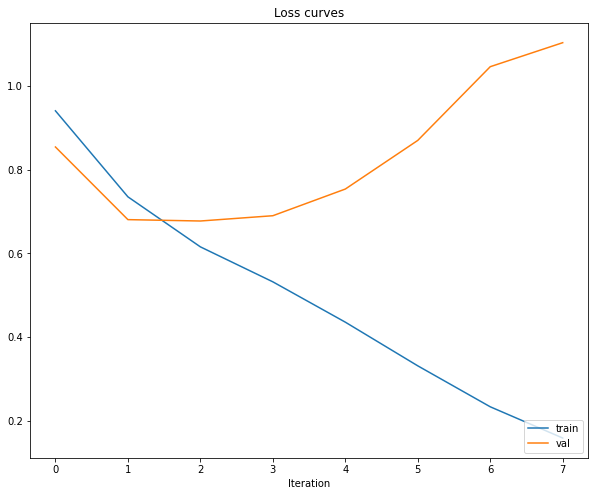

In [19]:
plt.title('Loss curves')
plt.plot(train_loss_history, '-', label='train')
plt.plot(val_loss_history, '-', label='val')
plt.legend(loc='lower right')
plt.xlabel('Iteration')
plt.show()

## Testing the Model

As we trained a model and improved it on the validation set, we can now test it on the test set.

In [20]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate, drop_last=False)

print("Accuracy on test set: {}".format(validation_metrics(model, test_loader)[1]),
        "RMSE on test set: {}".format(validation_metrics(model, test_loader)[2]))

Accuracy on test set: 0.6966813206672668 RMSE on test set: 0.543962950987113


## Demo

Now that we trained a sufficiently good sentiment classifier, let's run the below cell and type some text to see some predictions (type exit to quit the demo). Since we used a small data, don't expect too much :).

In [21]:
text = ''
w2i = vocab
while True:
    text = input()
    if text == 'exit':
        break
    
    words = torch.tensor([
        w2i.get(word, w2i['<unk>'])
        for word in nltk.word_tokenize(text)
    ]).long().to(device).view(-1, 1)  # T x B
    with torch.no_grad():
        pred = model(words).cpu()
        probs = F.softmax(pred, dim=1)
    prob, idx = torch.max(probs, dim=1)
    if idx == 0:
        txt = ':('
    elif idx == 1:
        txt = ':/'
    elif idx == 2:
        txt = ':)'
        
    print('Input text: {}\n'.format(text),
        'Sentiment -> {}, Confidence -> {:.3f}% '.format(txt, *prob*100))
    print()

Input text: awesome but expensive
 Sentiment -> :/, Confidence -> 49.853% 

Input text: expensive but awesome
 Sentiment -> :/, Confidence -> 72.764% 

Input text: comfortable place polite staff
 Sentiment -> :/, Confidence -> 70.134% 

Input text: loved it rooms could have been cleaner but food was great
 Sentiment -> :/, Confidence -> 59.210% 

Input text: loved it
 Sentiment -> :), Confidence -> 70.354% 

Input text: disgusting rooms, unbearable smell
 Sentiment -> :(, Confidence -> 96.715% 

Input text: totally worth the money, staff helpful, had a great time
 Sentiment -> :(, Confidence -> 69.592% 

Input text: kids loved it, great place to rest
 Sentiment -> :), Confidence -> 69.980% 

